# RFM Analizi ile Müşteri Segmentasyonu

*Müşterilerini segmentlere ayırmak isteyen bir e-ticaret şirketi bu segmentlere göre pazarlama stratejileri belirlemek istemektedir. Bunu gerçekleştirebilmek için müşterilerin davranışları tanımlanacak ve oluşan öbeklenmelere göre gruplar oluşturulacaktır. Ortak davranışlar sergileyenler aynı gruplarda yer alacak ve bu gruplara özel satış ve pazarlama teknikleri geliştirmeye çalışacaktır.*

https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

*Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içermektedir. Bu şirket hediyelik eşya satışı yapmaktadır. Promosyon ürünleri gibi düşünebilir ve müşterilerinin çoğu da toptancıdır.*

**DEĞİŞKENLER**

- **InvoiceNo:** *Fatura numarası. Her işleme yani faturaya ait eşsiz numara. Eğer bu kod C ile başlıyorsa işlemin iptal edildiğini ifade eder.*
- **StockCode:** *Ürün kodu. Her bir ürün için eşsiz numara.*
- **Description:** *Ürün ismi.*
- **Quantity:** *Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.*
- **InvoiceDate:** *Fatura tarihi ve zamanı.*
- **UnitPrice:** *Ürün fiyatı.(Sterlin cinsinden)*
- **CustomerID:** *Eşsiz müşteri numarası.*
- **Country:** *Ülke ismi. Müşterinin yaşadığı ülke.*

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
df_2010_2011 = pd.read_excel("online_retail_II.xlsx", sheet_name = "Year 2010-2011")

In [ ]:
df = df_2010_2011.copy()
#Hangi üründen kaç tane var?
df["Description"].value_counts().head()

In [ ]:
#Eşsiz ürün sayısı kaçtır?
df["Description"].nunique()

In [ ]:
#En çok sipariş edilen ürün hangisidir?
df.groupby("Description").agg({"Quantity":"sum"}).sort_values("Quantity", ascending = False).head()

In [ ]:
#Toplam kaç fatura kesilmiştir?
df["Invoice"].nunique()

In [ ]:
#Fatura başına ortalama kaç para kazanılmıştır?
df["TotalPrice"] = df["Quantity"]*df["Price"]

In [ ]:
df.groupby("Invoice").agg({"TotalPrice":"sum"}).head()
df.head()

In [ ]:
#En pahalı ürünler hangileridir?
df.sort_values("Price", ascending = False).head()

In [ ]:
#Hangi ülkeden kaç sipariş geldi?
df["Country"].value_counts()

In [ ]:
#Hangi ülke ne kadar kazandırdı?
df.groupby("Country").agg({"TotalPrice":"sum"}).sort_values("TotalPrice", ascending = False).head()

In [ ]:
#En çok iade alan ürün hangisidir? 
#Invoice değişkeninde başında "C" ifadesi yer alan ürünler iptal edilmiştir. Veri setinde şu anda boş yani değerler bulunmaktadır.
#Bu yüzden str.contains komutu içinde na değerlerini False olarak tanımlayıp görmezden geliyoruz. 
#Adet işlemi için de "Quantity" değişkenini azalan şekilde sıralayarak en çoktan en aza doğru iadeleri sıralayabiliriz.
return_ = df[df["Invoice"].str.contains("C", na=False)]
return_.sort_values("Quantity", ascending = True).head(3)

# Veri Ön İşleme

In [ ]:
#Eksik değer olup olmadığına bakıyoruz.
df.isnull().sum()

In [ ]:
df.shape

In [ ]:
#Eksik değerleri veri setinden çıkarıyoruz.
df.dropna(inplace = True)
df.shape

In [ ]:
#İstatistiksel değerleri, kartilleri inceleyerek veri seti hakkında bilgi ediniyoruz.
df.describe([0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95, 0.99]).T

# Kutu Grafiği ile Aykırı Gözlem Analizi

In [ ]:
for feature in ["Quantity","Price","TotalPrice"]:

    Q1 = df[feature].quantile(0.01)
    Q3 = df[feature].quantile(0.99)
    IQR = Q3-Q1
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR

    if df[(df[feature] > upper) | (df[feature] < lower)].any(axis=None):
        print(feature,"→ YES")
        print(df[(df[feature] > upper) | (df[feature] < lower)].shape[0])
    else:
        print(feature, "→ NO")

temiz_df=df[~((df[feature] > upper) | (df[feature] < lower)).any(axis=None)]

# RFM Skorları

RFM ifadesi Recency, Frequency, Monetary ifadelerinin baş harflerinden oluşur.
Müşterilerin satın alma alışkanlıkları üzerinden pazarlama ve satış stratejileri belirlemeye yardımcı olan bir tekniktir.

- Recency (Yenilik): Müşterinin son satın almasından bugüne kadar geçen süre

Diğer bir ifadesiyle “Müşterinin son temasından bugüne kadar geçen süre” dir. (Bugünün tarihi - Son satın alma) şeklinde bulunur.
Bugünün tarihi - son ürün satın alma tarihi. Çıkan değeri küçük olması istenir.

- Frequency (Sıklık): Toplam satın alma sayısı.

- Monetary (Parasal Değer): Müşterinin yaptığı toplam harcama.

In [ ]:
df.info()

# Recency Hesabı

In [ ]:
#Alışveriş yapılan ilk günü buluyoruz.
df["InvoiceDate"].min()

In [ ]:
#Alışveriş yapılan son günü buluyoruz.
df["InvoiceDate"].max()

In [ ]:
#İnceleyeceğimiz veriler 2010-2011 yılları arasında olduğu için bugünün tarihini kendimiz belirliyoruz.
import datetime as dt
today_date = dt.datetime(2011,12,9)
today_date

In [ ]:
#Müşteri ID'sine göre son yapılan alışveriş tarihlerine ulaşıyoruz.
df.groupby("Customer ID").agg({"InvoiceDate":"max"}).head()

In [ ]:
#(Bizim belirlediğimiz bugünün tarihi - alışveriş yapılan son tarih) işlemi yapıldığında recency değerini buluyoruz.
temp_df = (today_date - df.groupby("Customer ID").agg({"InvoiceDate":"max"}))
temp_df.rename(columns={"InvoiceDate": "Recency"}, inplace = True)
temp_df.head()

In [ ]:
#Saat değerlerini silmek için, daha önce burası Invoice Date değişkeni ve veri tipi datetime olduğu için days'leri seçip saatleri siliyoruz.
recency_df = temp_df["Recency"].apply(lambda x: x.days)
recency_df.head()

# Frequency Hesabı

In [ ]:
temp_df = df.groupby(["Customer ID","Invoice"]).agg({"Invoice":"count"})
temp_df.head()

In [ ]:
#Her müşteri kaç alışveriş yapmış toplamda bunu buluyoruz.
temp_df.groupby("Customer ID").agg({"Invoice":"count"}).head()

In [ ]:
#Yukarıda yapmış olduğumuz işlemi bir değişkene atayıp "Invoice" yazan değişkeni de "Frequency" olarak değiştirip gözlemliyoruz.
freq_df = temp_df.groupby("Customer ID").agg({"Invoice":"count"})
freq_df.rename(columns={"Invoice": "Frequency"}, inplace = True)
freq_df.head()

# Monetary Hesabı

In [ ]:
monetary_df = df.groupby("Customer ID").agg({"TotalPrice":"sum"})
monetary_df.head()

In [ ]:
#Sutün adlandırmasını değiştiriyoruz.
monetary_df.rename(columns={"TotalPrice": "Monetary"}, inplace = True)
monetary_df.head()

In [ ]:
print(recency_df.shape,freq_df.shape,monetary_df.shape)

# RFM Analizi 

*RFM Analizi için gerekli olan parametreler hesaplandıktan sonra yorum yapabilmek için bazı işlemler yapacağız.*

In [ ]:
#Parametreleri bir dataframe olarak concat fonksiyonu yardımı ile birleştiriyoruz.
rfm = pd.concat([recency_df, freq_df, monetary_df],  axis=1)
rfm.head()

In [ ]:
#Değerler görüldüğü üzere 1 ile 5 arasında olan değerlerdir. 5 çok iyi, 1 ise çok kötü anlamına gelmektedir.
rfm["RecencyScore"] = pd.qcut(rfm['Recency'], 5, labels = [5, 4, 3, 2, 1])
rfm["FrequencyScore"] = pd.qcut(rfm['Frequency'].rank(method = "first"), 5, labels = [1,2,3,4,5])
rfm["MonetaryScore"] = pd.qcut(rfm['Monetary'], 5, labels = [1, 2, 3, 4, 5])
rfm.head()

In [ ]:
#Skorları yanyana yazdırıyoruz.
(rfm['RecencyScore'].astype(str) + 
 rfm['FrequencyScore'].astype(str) + 
 rfm['MonetaryScore'].astype(str)).head()

In [ ]:
#RFM_SCORE sütununu Dataframe tablosuna ekliyoruz.
rfm["RFM_SCORE"] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str) + rfm['MonetaryScore'].astype(str)
rfm.head()

In [ ]:
#Betimsel istatistikleri inceliyoruz.
rfm.describe().T

In [ ]:
#En iyi müşteriler gösterilmektedir.
rfm[rfm["RFM_SCORE"] == "555"].head()

In [ ]:
#En kötü müşteriler gösterilmektedir.
rfm[rfm["RFM_SCORE"] == "111"].head()

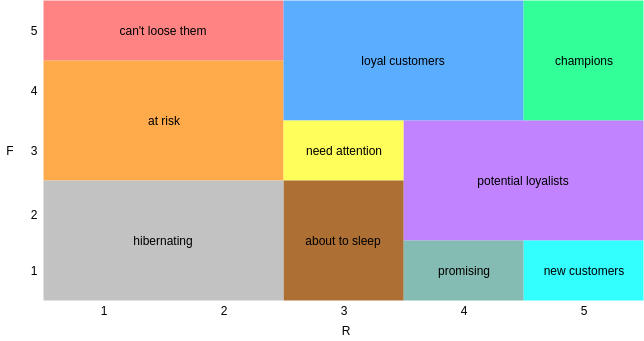

In [ ]:
#RFM skorlarına göre müşterileri sınıflara atıyoruz. Bu sınıfların hangi skor aralığında olacağı aşağıda belirtilmiştir. 
#Örnek olarak Hibernating sınıfı şu skor değerlerine sahiptir. 
#Recency değeri 1-2, Frequency değeri 1-2 olanlardır diğer sınıflarda bu şekilde okunmaktadır.
#Buraya sadece Recency ve Frequency eklenmesinin sebebi tabloda sadece bu iki parametre yer almaktadır.
#Ancak Monetary de eklenebilir.
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [ ]:
#Yukarıda tanımlanan seg_map'i dataframe tablosuna dahil ediyoruz.
rfm['Segment'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

In [ ]:
#Segmentlere göre groupby yaparak elde edilen 3 parametrenin ortalama ve kaç adet olduğunu buluyoruz.
rfm[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count"])

In [ ]:
#"Need Attention" grubunu yakalıyoruz.
rfm[rfm["Segment"] == "Need Attention"].head()

In [ ]:
#Dikkat gerektiren müşterilerin Customer ID (indeks) değerlerine erişilmiştir.
#Yeni müşterilere özel promosyonlar ve mailler bu ID'ler sayesinde atılabilir.
rfm[rfm["Segment"] == "Need Attention"].index

In [ ]:
#Yeni bir dataframe oluşturularak içerisine Need Attention grubuna ait müşterilerin ID bilgileri atıyoruz.
new_df = pd.DataFrame()
new_df["NewCustomerID"] = rfm[rfm["Segment"] == "Need Attention"].index
new_df.head()

In [ ]:
#Atanan bu ID'ler csv çıktısı alınarak kullanıma hazır hale getirilmiştir.
new_df.to_csv("new_customers.csv")

# Yorumlama

In [ ]:
rfm[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count","max"]).head(10)

Yorum yaparken Recency değerinin düşük, Frequency değerinin yüksek ve Monetary değerinin yüksek olmasını dikkate alacağız.
Buna göre seçilecek olan 4 grup şunlardır;

- Champions
- Can't Loose
- Loyal Customers
- Need Attention

**Champions**

665 kişi bulunan bu grupta ortalama olarak en son alışveriş 4 gün önce gerçekleşmiş,
alışveriş sıklıkları 15, toplamda 248 alışveriş var, ort. 6510 dolar/TL harcamaları var.

**Can't Loose**

68 kişi bulunan bu grupta ortalama olarak en son alışveriş 132 gün önce gerçekleşmiş,
alışveriş sıklıkları 10, toplamda 35 alışverişleri var, ort. 2381 dolar/TL harcamaları var.

**Loyal Customers**

795 kişi bulunan bu grupta ortalama olarak en son alışveriş 31 gün önce gerçekleşmiş,
alışveriş sıklıkları 8, toplamda 76 alışverişleri var, ort. 2703 dolar/TL harcamaları var.

**Need Attention**

190 kişi bulunan bu grupta ortalama olarak en son alışveriş 48 gün önce gerçekleşmiş,
alışveriş sıklıkları 3, toplamda 4 alışverişleri var, ort. 790 dolar/TL harcamaları var.


_**AKSİYON ÇALIŞMALARI**_

Champions grubundaki müşteriler büyük ihtimalle toplam gelirin yüksek bir yüzdesini oluşturmaktadır. Bu nedenle onları memnun etmeye odaklanmak en büyük öncelik olmalıdır. Tercihlerini daha iyi araştırıp analiz ederek, daha kişiselleştirilmiş ve özel fırsatlar oluşturulmalıdır. Ürünleri onlar için özelleştirerek promosyon şeklinde göndermek hem onları memnun edeceek hem de ürünün tanıtımı açısından yararlı olacaktır.

Can't Loose grubuna çok dikkat ve önem verilmelidir. Bu kaybedilmek istenmeyen gruptur. Toplam gelirde hatrı sayılır yüzdeye sahiplerdir. Toplu bir şekilde alışveriş yapıp uzun bir süre tekrar alışveriş yapmamaktadırlar. Bu gruba özel promosyonlar hazırlanarak firma bünyesinde tutulabilirler.

Loyal Customers grubundaki kişilere popüler ürünler indirimli olarak önerilebilir. Toplam yapılan alışveriş sayısı 76'dır ve oldukça yüksek bir sayıdır.

Need Attention grubundaki kişilere sınırlı süreli teklifler yapılabilir. Bu onları harekete geçirerek alışveriş yapma eylemine itecektir. Geçmiş satın alımlar incelenerek tavsiyelerde bulunulmalıdır. Bu onları yeniden etkin hale getirecektir.